In [1]:
# Import libraries
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import yfinance as yf
import warnings
warnings.simplefilter("ignore")
plt.style.use('ggplot')


In [2]:
# Read data
Df = yf.download('NVDA', '2015-01-01', '2024-10-14', auto_adjust=True)
Df.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2015-01-02,0.483038,0.486638,0.475360,0.483038,113680000
2015-01-05,0.474880,0.484478,0.472720,0.483038,197952000
2015-01-06,0.460482,0.476079,0.460002,0.475600,197764000
2015-01-07,0.459282,0.467921,0.457843,0.463841,321808000
2015-01-08,0.476559,0.479439,0.464321,0.464561,283780000


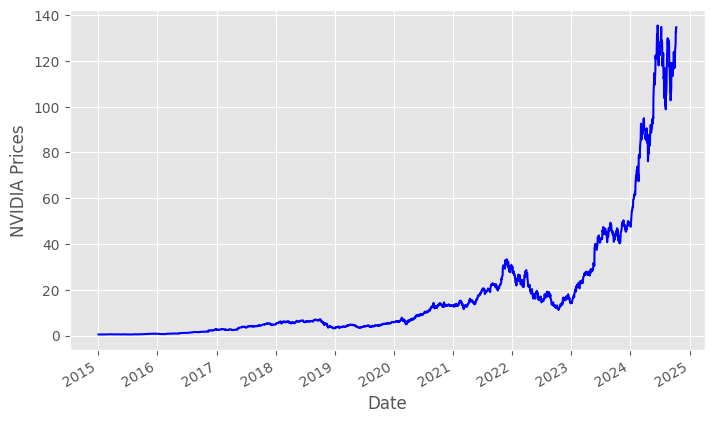

In [3]:
if isinstance(Df.columns, pd.MultiIndex):
    Df.columns = Df.columns.droplevel(1)
# Only keep close columns
Df = Df[['Close']]
# Drop rows with missing values
Df = Df.dropna()
# Plot the closing price of gold
Df.Close.plot(figsize=(8.2, 5), color='b')

plt.ylabel("NVIDIA Prices")
plt.show()

In [4]:
# Define explanatory variables
Df['S_3'] = Df['Close'].rolling(window=3).mean()
Df['S_9'] = Df['Close'].rolling(window=9).mean()
Df['next_day_price'] = Df['Close'].shift(-1)

Df = Df.dropna()
X = Df[['S_3', 'S_9']]

# Define dependent variable
y = Df['next_day_price']

In [5]:
# Cointegration testing
S_3 = Df['S_3'].dropna()
S_9 = Df['S_9'].dropna()

# Since S_3 and S_9 are moving averages, we could check their cointegration with the original Close series
close_price = Df['next_day_price']

# Conduct Engle-Granger Cointegration Test between S_3 and Close price
coint_result_3 = coint(S_3, close_price)

# Conduct Engle-Granger Cointegration Test between S_9 and Close price
coint_result_9 = coint(S_9, close_price)

# Extract p-values
p_value_3 = coint_result_3[1]
p_value_9 = coint_result_9[1]

# Print the results
print(f"Cointegration p-value between S_3 and next_day_price: {p_value_3}")
print(f"Cointegration p-value between S_9 and next_day_price: {p_value_9}")

# Interpretation
alpha = 0.05
if p_value_3 < alpha:
    print("S_3 and next_day_price are cointegrated.")
else:
    print("S_3 and next_day_price are not cointegrated.")

if p_value_9 < alpha:
    print("S_9 and next_day_price are cointegrated.")
else:
    print("S_9 and next_day_price are not cointegrated.")

Cointegration p-value between S_3 and next_day_price: 1.2673631721258431e-14
Cointegration p-value between S_9 and next_day_price: 8.415560328208823e-12
S_3 and next_day_price are cointegrated.
S_9 and next_day_price are cointegrated.


In [6]:
# Split the data into train and test dataset
t = .8
t = int(t*len(Df))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

# Create a linear regression model
linear = LinearRegression().fit(X_train, y_train)
print("Linear Regression model")
print("NVIDIA Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 9 Days Moving Average (x2) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))

Linear Regression model
NVIDIA Price (y) = 1.25 * 3 Days Moving Average (x1) + -0.25 * 9 Days Moving Average (x2) + 0.02 (constant)


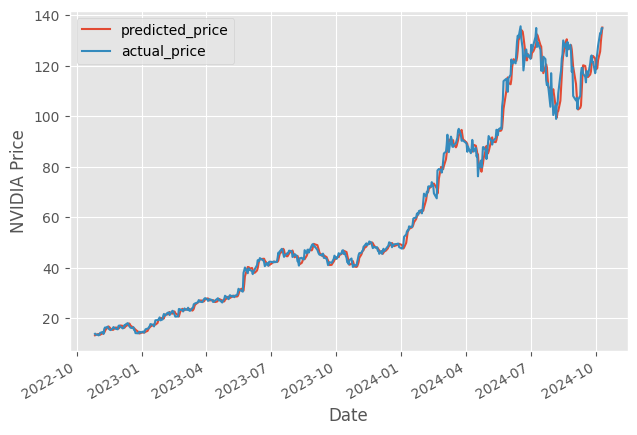

R-squared: 99.41%


In [7]:
# Predicting the NVIDIA prices
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])

predicted_price.plot(figsize=(7.2, 5))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("NVIDIA Price")
plt.show()

# R square
r2_score = linear.score(X[t:], y[t:])*100
print(f"R-squared: {float('{0:.2f}'.format(r2_score))}%")

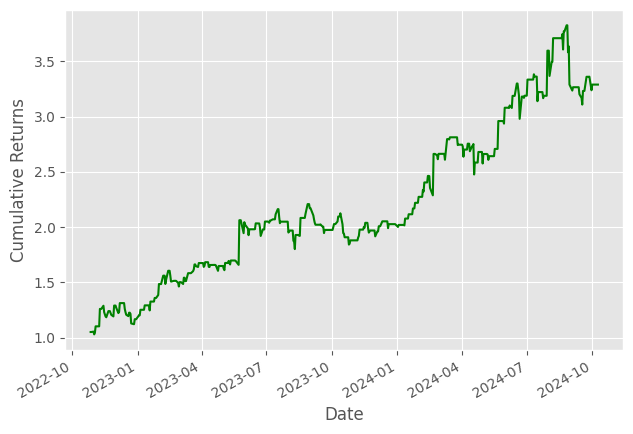

Sharpe Ratio 1.66


In [8]:
# Calculate cumulative returns
NVIDIA = pd.DataFrame()

NVIDIA['price'] = Df[t:]['Close']
NVIDIA['predicted_price_next_day'] = predicted_price
NVIDIA['actual_price_next_day'] = y_test
NVIDIA['gold_returns'] = NVIDIA['price'].pct_change().shift(-1)

NVIDIA['signal'] = np.where(NVIDIA.price < NVIDIA.predicted_price_next_day,1,0)

NVIDIA['strategy_returns'] = NVIDIA.signal * NVIDIA['gold_returns']
((NVIDIA['strategy_returns']+1).cumprod()).plot(figsize=(7.2, 5), color='g')
plt.ylabel('Cumulative Returns')
plt.show()

# Calculate sharpe ratio
sharpe = NVIDIA['strategy_returns'].mean()/NVIDIA['strategy_returns'].std()*(252**0.5)
print('Sharpe Ratio %.2f' % (sharpe))


In [9]:
# Signal generation for daily moves
import datetime as dt
current_date = dt.datetime.now()

# Get the data
data = yf.download('NVDA', '2012-01-01', '2025-11-14', auto_adjust=True)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(1)

data['S_3'] = data['Close'].rolling(window=3).mean()
data['S_9'] = data['Close'].rolling(window=9).mean()
data = data.dropna()

# Forecast the price
data['predicted_NVIDIA_price'] = linear.predict(data[['S_3', 'S_9']])
data['signal'] = np.where(data.Close < data.predicted_NVIDIA_price,"Buy","No Position")

[*********************100%***********************]  1 of 1 completed


In [10]:
# Print the forecast
print("Latest Signal and Prediction:")
data.tail(1)[['Close','signal','predicted_NVIDIA_price']].T

Latest Signal and Prediction:


Date,2025-10-14
Price,
Close,180.029999
signal,Buy
predicted_NVIDIA_price,182.776433
